In [1]:
from tqdm.auto import tqdm
from sentence_transformers import evaluation
import torch 
from transformers import BertModel
from transformers import BertTokenizer
from datasets import Dataset
import pandas as pd
from transformers.optimization import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt 
import numpy as np
import sklearn.model_selection
from sentence_transformers import SentenceTransformer, InputExample, losses

In [2]:
#load data 
df = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/enTrainData.csv", sep="\t")
df = df.loc[(df["url1_lang"] == "en") & (df["url2_lang"] == "en")]

#put ground truth values into a list 
df["ground_truth"] = df['Overall']

#TODO: do we need to make data tensors or does this happen when we call set_format() later on
#df["ground_truth"] = df["ground_truth"].apply(torch.tensor)

#[torch.tensor(gtList) for gtList in df["ground_truth"]]

#get only the columns we need 
#TODO: do we need "pair_id"? 
leanDf = df[["Overall", "Tone",  'text1', 'text2']].dropna()


In [3]:
#scale values so they work for cosine similarity 
selectedCols = ["Overall", "Tone"]
for col in selectedCols: 
    leanDf[col] = 1 - (leanDf[col] / 4)

In [4]:
print(df.shape)
print(len(df["link1"].unique()))
print(len(df["link2"].unique()))

(1690, 20)
1684
1510


In [5]:
deviceNum = 1
def check_mem():
    torch.cuda.empty_cache()
    a = torch.cuda.memory_allocated(deviceNum)/1024/1024/1024
    r = torch.cuda.memory_reserved(deviceNum)/1024/1024/1024
    print("torch.cuda.memory_allocated: %fGB"%a)
    print("torch.cuda.memory_reserved: %fGB"%r)
    print("torch.cuda.memory_free: %fGB"%(r-a))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(deviceNum)/1024/1024/1024))
check_mem()

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


In [6]:
#split data 
trainDf, validDf = sklearn.model_selection.train_test_split(leanDf, train_size=.75, test_size=.25)
trainDf = trainDf.reset_index(drop=True)
trainDf.head(2)

,Overall,Tone,text1,text2
0,0.083333,0.50,A woman was killed early Tuesday when a massiv...,"MITCHELL, Jennie L. Age 87, of Atlanta, passed..."
1,0.083333,0.25,The political backdrop of 2019 truly tested in...,"EL SEGUNDO — To welcome in the next decade, th..."


In [7]:
trainOverall = []
trainTone = []
for row in trainDf.itertuples(): 
    trainOverall.append(InputExample(texts =[row[3], row[4]], label=row[1]))
    trainTone.append(InputExample(texts =[row[3], row[4]], label=row[2]))

In [8]:
#build model 

"""
from sentence_transformers import SentenceTransformer, models

word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
"""

"\nfrom sentence_transformers import SentenceTransformer, models\n\nword_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=256)\npooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())\n\nmodel = SentenceTransformer(modules=[word_embedding_model, pooling_model])\n"

In [9]:
#Define the model. Either from scratch of by loading a pre-trained model
#del model 
torch.cuda.empty_cache()

model = SentenceTransformer('all-mpnet-base-v2', device="cuda:" + str(deviceNum))

#Define your train examples. You need more than just two examples...
#train_examples = [InputExample(texts=['My first sentence', 'My second sentence'], label=0.8),
#    InputExample(texts=['Another pair', 'Unrelated sentence'], label=0.3)]

#Define your train dataset, the dataloader and the train loss
overallDataloader = torch.utils.data.DataLoader(trainOverall, shuffle=True, batch_size=5)
toneDataloader = torch.utils.data.DataLoader(trainTone, shuffle=True, batch_size=5)

#works OK 
#train_loss = losses.MultipleNegativesRankingLoss(model)

overallLoss = losses.CosineSimilarityLoss(model)
toneLoss = losses.CosineSimilarityLoss(model)

evaluator = evaluation.EmbeddingSimilarityEvaluator(list(validDf["text1"]), list(validDf["text2"]), list(validDf["Tone"]))

check_mem()

train_objectives = [(overallDataloader, overallLoss),(toneDataloader, toneLoss)]
#Tune the model
output_path = "/shared/3/projects/benlitterer/localNews/NetworkMVP/SBERTmultitaskEval"
checkpoint_path = "/shared/3/projects/benlitterer/localNews/NetworkMVP/SBERTmultitaskTraining"
evaluation_steps = 50
model.fit(train_objectives=train_objectives, epochs=2, warmup_steps=75, evaluator=evaluator, evaluation_steps = evaluation_steps, output_path=output_path, checkpoint_path=checkpoint_path)

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/252 [00:00<?, ?it/s]

Iteration:   0%|          | 0/252 [00:00<?, ?it/s]

In [16]:
evalData = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/SBERTmultitaskEval/eval/similarity_evaluation_results.csv")

In [17]:
evalData

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,0,50,0.490563,0.504727,0.484866,0.504727,0.485585,0.503583,0.490563,0.504727
1,0,100,0.511936,0.535218,0.496313,0.535218,0.494564,0.532283,0.511936,0.535218
2,0,150,0.493913,0.511528,0.486590,0.511528,0.482725,0.506622,0.493913,0.511528
3,0,200,0.535632,0.559082,0.522391,0.559082,0.516921,0.551786,0.535632,0.559082
4,0,250,0.520619,0.543597,0.508224,0.543597,0.501271,0.536497,0.520619,0.543597
5,0,-1,0.520824,0.543673,0.508540,0.543673,0.501724,0.536216,0.520824,0.543673
6,1,50,0.530825,0.556270,0.517885,0.556270,0.512195,0.549309,0.530825,0.556270
7,1,100,0.525061,0.549493,0.511797,0.549493,0.504851,0.539700,0.525061,0.549493
8,1,150,0.525260,0.551862,0.509847,0.551862,0.504254,0.542536,0.525260,0.551862
9,1,200,0.522727,0.548547,0.507778,0.548547,0.501952,0.537482,0.522727,0.548547


In [19]:
plotData = evalData[evalData["steps"] != -1]
currStep = 0 
evaluation_steps = 50 
totalSteps = []
for i in range(len(plotData)):
    totalSteps.append(currStep)
    currStep += evaluation_steps 
    
plotData["totalSteps"] = totalSteps

<ipython-input-19-97c093916601>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotData["totalSteps"] = totalSteps


In [20]:
plotData["totalSteps"] / 252

0     0.000000
1     0.198413
2     0.396825
3     0.595238
4     0.793651
6     0.992063
7     1.190476
8     1.388889
9     1.587302
10    1.785714
Name: totalSteps, dtype: float64

Text(0, 0.5, 'Cosine Similarity, Pearson Correlation')

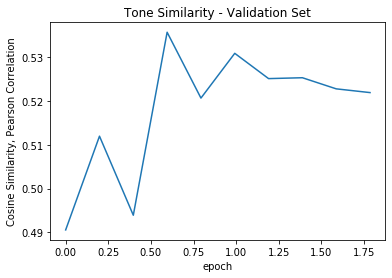

In [22]:

plt.plot(plotData["totalSteps"] / 252, plotData["cosine_pearson"])
plt.title("Tone Similarity - Validation Set")
plt.xlabel("epoch")
plt.ylabel("Cosine Similarity, Pearson Correlation")

In [24]:
evaluator = evaluation.EmbeddingSimilarityEvaluator(list(validDf["text1"]), list(validDf["text2"]), list(validDf["Overall"]))
evaluator(model, output_path=output_path + "/overallSimEval")

0.8139453681490335